In [2]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']

In [5]:
miceList = getMiceList(Files[0])

In [ ]:
# save all full spectograms in hdf5 file:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('Spectograms.hdf5','a')

fr = np.empty((408,1))
for j in range(12,420):
    fr[j-12]=pywt.scale2frequency('morl', j)*3051.7578125
[intF,inds] = np.unique(np.floor(fr),return_index=True)

waveletName = 'morl' #must be from waveletsOptions
scales = inds+12

for m in miceList:
    grp = f.create_group(m)
    data_pre = getData(Files[0],['lfp'],period ='Pre', mice=m)
    data_post = getData(Files[0],['lfp'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    for aa in tqdm(range(0,len(data_pre))):
        sess = dKeys[a[aa]]
        lfp = data_pre[sess]['lfp']['lfp']
        FS = data_pre[sess]['lfp']['FS']
        dt = 1/FS
        [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
        
        subgrp = grp.create_group(sess)
        ssubgrp = subgrp.create_group('Pre')
        ssubgrp['freq'] = frequencies
        ssubgrp['coeff'] = coefficients
        del frequencies
        del coefficients
        if sess in data_post.keys():
            lfp = data_post[sess]['lfp']['lfp']
            FS = data_post[sess]['lfp']['FS']
            [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
            spsubgrp = subgrp.create_group('Post')
            spsubgrp['freq'] = frequencies
            spsubgrp['coeff'] = coefficients
            del frequencies
            del coefficients
        
f.close()   

In [10]:
speedOnsetPars = {}
for m in miceList:
    data = getData(Files[0],['speed'],period ='Pre',mice=m, day = lambda x: x==0)
    maxSpeed = [];
    for sess in data:
        speed = smooth(data[sess]['speed']['speed'],20)
        maxSpeed.append(np.max(speed))
    hi = np.mean(maxSpeed)/4
    print(m,' hi: ',hi)
    speedOnsetPars[m] = hi

cleaning up speed data
0761  hi:  9.093602196045618
cleaning up speed data
1208  hi:  8.771471533672353
cleaning up speed data
1222  hi:  5.156689209415026
cleaning up speed data
1231  hi:  11.618820172401003
cleaning up speed data
1236  hi:  4.7582281732347065
cleaning up speed data
1253  hi:  6.589833466357713
cleaning up speed data
1793  hi:  6.682175945902453
cleaning up speed data
2976  hi:  3.31284333461864
cleaning up speed data
2980  hi:  2.454958217734436
cleaning up speed data
2981  hi:  6.1404716594406485
cleaning up speed data
4539  hi:  20.02124398644328
cleaning up speed data
7584  hi:  20.05099337143352
cleaning up speed data
7909  hi:  19.047091800698265
cleaning up speed data
8430  hi:  9.830010517302346
cleaning up speed data
8803  hi:  4.064502492829341
cleaning up speed data
8815  hi:  5.469190903653327


D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


In [11]:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('OnsetsAndPeriods.hdf5','a')

hiWin=20 
thWin=40
th_strong = 1
shift=2

miceList = speedOnsetPars.keys()
for m in miceList:
    grp = f.create_group(m)
    sgrp = grp.create_group('mvmtOnset_params')
    sgrp.attrs['hi'] = speedOnsetPars[m]
    sgrp.attrs['th_weak'] = np.min([3.3, speedOnsetPars[m]/2.5])
    sgrp.attrs['hiWin'] = hiWin
    sgrp.attrs['thWin'] = thWin
    sgrp.attrs['th_strong'] = th_strong
    sgrp.attrs['shift'] = shift
    data_pre = getData(Files[0],['speed'],period ='Pre', mice=m)
    data_post = getData(Files[0],['speed'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    hi = sgrp.attrs['hi']
    th_weak = sgrp.attrs['th_weak']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        speed = data_pre[sess]['speed']['speed']
        speed = speed.T
        sOnset = FindMvmtOnset2(speed, th_weak,th_strong ,hi,hiWin,thWin,shift)
        subgrp = grp.create_group(sess)
        ssubgrp = subgrp.create_group('Pre')
        ssubgrp['mvmtOnset'] = sOnset
        if sess in data_post.keys():
            speed = data_post[sess]['speed']['speed']
            speed = speed.T
            sOnset = FindMvmtOnset2(speed, th_weak,th_strong ,hi,hiWin,thWin,shift)
            spsubgrp = subgrp.create_group('Post')
            spsubgrp['mvmtOnset'] = sOnset
        
f.close()   

cleaning up speed data
cleaning up speed data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up speed data
cleaning up speed data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up speed data
cleaning up speed data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I delet

In [17]:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('OnsetsAndPeriods.hdf5','a')

hiWin=20 
thWin=40
th_strong = 1
shift=-6

miceList = speedOnsetPars.keys()
for m in miceList:
    grp = f[m]
#     del grp['mvmtOnset2_params']
    try:
        sgrp = grp.create_group('mvmtOnset2_params')
    except:
        sgrp = grp['mvmtOnset2_params']
    sgrp.attrs['hi'] = speedOnsetPars[m]
    sgrp.attrs['th_weak'] = np.min([3.3, speedOnsetPars[m]/2.5])
    sgrp.attrs['hiWin'] = hiWin
    sgrp.attrs['thWin'] = thWin
    sgrp.attrs['th_strong'] = th_strong
    sgrp.attrs['shift'] = shift
    data_pre = getData(Files[0],['speed'],period ='Pre', mice=m)
    data_post = getData(Files[0],['speed'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    hi = sgrp.attrs['hi']
    th_weak = sgrp.attrs['th_weak']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        speed = data_pre[sess]['speed']['speed']
        speed = speed.T
        sOnset = FindMvmtOnset2(speed, th_weak,th_strong ,hi,hiWin,thWin,shift)
        subgrp = grp[sess]
        ssubgrp = subgrp['Pre']
#         del ssubgrp['mvmtOnset2']
        try:
            ssubgrp['mvmtOnset2'] = sOnset
        except:
            del ssubgrp['mvmtOnset2']
            ssubgrp['mvmtOnset2'] = sOnset
        if sess in data_post.keys():
            speed = data_post[sess]['speed']['speed']
            speed = speed.T
            sOnset = FindMvmtOnset2(speed, th_weak,th_strong ,hi,hiWin,thWin,shift)
            spsubgrp = subgrp['Post']
#             del spsubgrp['mvmtOnset2'] 
            try:
                spsubgrp['mvmtOnset2'] = sOnset
            except:
                del spsubgrp['mvmtOnset2']
                spsubgrp['mvmtOnset2'] = sOnset
        
f.close()   

cleaning up speed data
cleaning up speed data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up speed data
cleaning up speed data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up speed data
cleaning up speed data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I delet

In [18]:
highSpeedPeriodsPars = {}
for m in miceList:
    data = getData(Files[0],['speed'],period ='Pre',mice=m, day = lambda x: x==0)
    maxSpeed = [];
    for sess in data:
        speed = smooth(data[sess]['speed']['speed'],20)
        maxSpeed.append(np.max(speed))
    hth = np.mean(maxSpeed)/5
    lth = np.mean(maxSpeed)/10
    print(m,' hth: ',hth,' lth: ',lth)
    highSpeedPeriodsPars[m] = {'hth':hth,'lth':lth}

cleaning up speed data
0761  hth:  7.2748817568364945  lth:  3.6374408784182473
cleaning up speed data
1208  hth:  7.017177226937882  lth:  3.508588613468941
cleaning up speed data
1222  hth:  4.125351367532021  lth:  2.0626756837660105
cleaning up speed data
1231  hth:  9.295056137920803  lth:  4.647528068960401
cleaning up speed data
1236  hth:  3.806582538587765  lth:  1.9032912692938826
cleaning up speed data
1253  hth:  5.27186677308617  lth:  2.635933386543085
cleaning up speed data
1793  hth:  5.345740756721963  lth:  2.6728703783609813
cleaning up speed data
2976  hth:  2.650274667694912  lth:  1.325137333847456
cleaning up speed data
2980  hth:  1.9639665741875487  lth:  0.9819832870937744
cleaning up speed data
2981  hth:  4.912377327552519  lth:  2.4561886637762593
cleaning up speed data
4539  hth:  16.016995189154624  lth:  8.008497594577312
cleaning up speed data
7584  hth:  16.040794697146815  lth:  8.020397348573407
cleaning up speed data
7909  hth:  15.237673440558613  

<IPython.core.display.Javascript object>


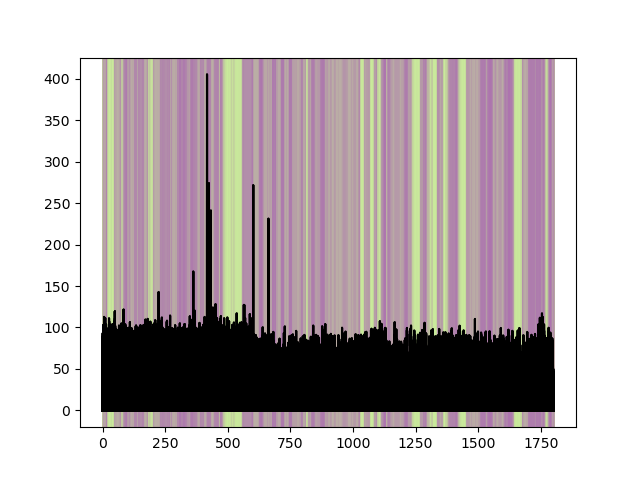

cleaning up speed data
cleaning up speed data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


cleaning up speed data
cleaning up speed data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

cleaning up speed data
cleaning up speed data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

In [19]:
f = h5py.File('OnsetsAndPeriods.hdf5','a')
Colors = CP('highLowSpeed')

fig, ax = plt.subplots(1,1)

Tseconds = 1

miceList = getMiceList(Files[0])
for m in miceList:
    grp = f[m]
    sgrp = grp.create_group('highLowSpeedPeriods_params')
    sgrp.attrs['th_high'] = highSpeedPeriodsPars[m]['hth']
    sgrp.attrs['th_low'] = highSpeedPeriodsPars[m]['lth']
    
    data_pre = getData(Files[0],['speed'],period ='Pre', mice=m)
    data_post = getData(Files[0],['speed'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    th_hi = sgrp.attrs['th_high']
    th_low = sgrp.attrs['th_low']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        speed = data_pre[sess]['speed']['speed']
        speed = speed.T
        dt  = 1/data_pre[sess]['speed']['Fs']
        dataPoints = int(np.ceil(Tseconds/dt))
        
        
        HPeriods = HighSpeedPeriods(ax,speed,dt,th_hi, dataPoints,Colors['high'])
        LPeriods = LowSpeedPeriods(ax,speed,dt,th_low, dataPoints,Colors['low'])
        
        subgrp = grp[sess]
        ssubgrp =subgrp['Pre']
        ssubgrp['HighMvmtPeriods_StartSegments'] = HPeriods['highSpeed']['start']
        ssubgrp['HighMvmtPeriods_EndSegments'] = HPeriods['highSpeed']['end']
        highP = np.full(speed.shape, False)
        for l in range(0, len(HPeriods['highSpeed']['start'])):
            highP[HPeriods['highSpeed']['start'][l]:HPeriods['highSpeed']['end'][l]] = True
        ssubgrp['HighMvmtPeriods_vector'] = highP
        
        ssubgrp['LowMvmtPeriods_StartSegments'] = LPeriods['lowSpeed']['start']
        ssubgrp['LowMvmtPeriods_EndSegments'] = LPeriods['lowSpeed']['end']
        lowP = np.full(speed.shape, False)
        for l in range(0, len(LPeriods['lowSpeed']['start'])):
            lowP[LPeriods['lowSpeed']['start'][l]:LPeriods['lowSpeed']['end'][l]] = True
        ssubgrp['LowMvmtPeriods_vector'] = lowP
        
        if sess in data_post.keys():
            speed = data_post[sess]['speed']['speed']
            speed = speed.T
           
            
            HPeriods = HighSpeedPeriods(ax,speed,dt,th_hi, dataPoints,Colors['high'])
            LPeriods = LowSpeedPeriods(ax,speed,dt,th_low, dataPoints,Colors['low'])

            spsubgrp = subgrp['Post']
            spsubgrp['HighMvmtPeriods_StartSegments'] = HPeriods['highSpeed']['start']
            spsubgrp['HighMvmtPeriods_EndSegments'] = HPeriods['highSpeed']['end']
            highP = np.full(speed.shape, False)
            for l in range(0, len(HPeriods['highSpeed']['start'])):
                highP[HPeriods['highSpeed']['start'][l]:HPeriods['highSpeed']['end'][l]] = True
            spsubgrp['HighMvmtPeriods_vector'] = highP

            spsubgrp['LowMvmtPeriods_StartSegments'] = LPeriods['lowSpeed']['start']
            spsubgrp['LowMvmtPeriods_EndSegments'] = LPeriods['lowSpeed']['end']
            lowP = np.full(speed.shape, False)
            for l in range(0, len(LPeriods['lowSpeed']['start'])):
                lowP[LPeriods['lowSpeed']['start'][l]:LPeriods['lowSpeed']['end'][l]] = True
            spsubgrp['LowMvmtPeriods_vector'] = lowP
        
f.close()  

In [ ]:
f = h5py.File('OnsetsAndPeriods.hdf5','a')
for m in miceList:
    data = getData(Files[1],['trace'],period ='Pre', mice=m)
    grp = f[m]
    try:
        del grp['caOnset_params']
    except:
        # do nothing
        b=1
    sgrp = grp.create_group('caOnset_params')
    sgrp.attrs['tapers'] = [2,3]
    sgrp.attrs['std_threshold'] = 7
    sgrp.attrs['window_size'] = 1
    sgrp.attrs['pre_window'] = 20
    sgrp.attrs['max_fall'] = 4
    for sess in tqdm(data):
        print(sess)
        # get traces:
        dff = data[sess]['trace']['dff']
        Fs = data[sess]['trace']['FS'][0]
        caOnset,caFall = caSpikeFinder(dff,Fs)
        caOnset[np.isnan(caOnset)] = 0
        caFall[np.isnan(caFall)] = 0
        subgrp = grp[sess]
        ssubgrp =subgrp['Pre']
        try: 
            del ssubgrp['caOnset_Hf']
            del ssubgrp['eventStart_Hf']
        except: 
            # do nothing...
            b=1
        ssubgrp['caOnset_Hf'] = caOnset
        ssubgrp['caFall_Hf'] = caFall
f.close()

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
0761_BaselineA


  7%|█████▊                                                                            | 1/14 [02:02<26:35, 122.71s/it]

0761_BaselineL


 14%|███████████▋                                                                      | 2/14 [04:34<26:17, 131.44s/it]

0761_BaselineS


 21%|█████████████████▌                                                                | 3/14 [07:14<25:38, 139.86s/it]

0761_day1


 29%|███████████████████████▍                                                          | 4/14 [07:27<17:00, 102.00s/it]

0761_day10


 36%|█████████████████████████████▎                                                    | 5/14 [09:19<15:44, 104.95s/it]

0761_day12


 43%|███████████████████████████████████▌                                               | 6/14 [10:08<11:45, 88.24s/it]

0761_day14A


 50%|█████████████████████████████████████████▌                                         | 7/14 [10:23<07:43, 66.28s/it]

0761_day19L


 57%|███████████████████████████████████████████████▍                                   | 8/14 [12:11<07:51, 78.55s/it]

0761_day2


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [13:36<06:43, 80.73s/it]

0761_day31A


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [15:30<06:02, 90.70s/it]

0761_day35L


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [16:55<04:26, 88.87s/it]

0761_day4


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [17:57<02:41, 80.78s/it]

0761_day6


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [19:02<01:16, 76.21s/it]

0761_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
1208_BaselineA


  7%|█████▋                                                                         | 1/14 [24:18<5:15:57, 1458.27s/it]

1208_BaselineL


 14%|███████████▎                                                                   | 2/14 [52:27<5:05:30, 1527.53s/it]

1208_BaselineS


 21%|████████████████▌                                                            | 3/14 [1:10:30<4:15:36, 1394.22s/it]

1208_day10


 29%|██████████████████████                                                       | 4/14 [1:23:41<3:22:12, 1213.30s/it]

1208_day12


 36%|███████████████████████████▌                                                 | 5/14 [1:45:04<3:05:06, 1234.06s/it]

1208_day14


 43%|█████████████████████████████████                                            | 6/14 [2:03:27<2:39:17, 1194.73s/it]

1208_day15A


 50%|██████████████████████████████████████▌                                      | 7/14 [2:16:11<2:04:19, 1065.65s/it]

1208_day19L


 57%|████████████████████████████████████████████▌                                 | 8/14 [2:24:24<1:29:22, 893.83s/it]

1208_day2


 64%|██████████████████████████████████████████████████▏                           | 9/14 [2:40:54<1:16:52, 922.53s/it]

1208_day30A


 71%|████████████████████████████████████████████████████████▍                      | 10/14 [2:54:30<59:22, 890.58s/it]

1208_day34L


 79%|██████████████████████████████████████████████████████████████                 | 11/14 [3:09:18<44:29, 889.84s/it]

1208_day4


 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [3:26:29<31:04, 932.31s/it]

1208_day6


 93%|████████████████████████████████████████████████████████████████████████▍     | 13/14 [3:45:48<16:40, 1000.18s/it]

1208_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
1222_BaselineA


  7%|█████▊                                                                            | 1/14 [03:53<50:33, 233.38s/it]

1222_BaselineL


 14%|███████████▍                                                                    | 2/14 [13:19<1:06:40, 333.34s/it]

1222_BaselineS
skipped iteration


 21%|█████████████████▏                                                              | 3/14 [23:49<1:17:24, 422.20s/it]

1222_day11


 29%|███████████████████████▍                                                          | 4/14 [25:19<53:45, 322.57s/it]

1222_day13


 36%|█████████████████████████████▎                                                    | 5/14 [28:10<41:32, 276.92s/it]

1222_day15A


 43%|███████████████████████████████████▏                                              | 6/14 [33:42<39:09, 293.74s/it]

1222_day2


 50%|█████████████████████████████████████████                                         | 7/14 [33:48<24:10, 207.16s/it]

1222_day20L


 57%|██████████████████████████████████████████████▊                                   | 8/14 [39:36<24:57, 249.59s/it]

1222_day3


 64%|████████████████████████████████████████████████████▋                             | 9/14 [42:14<18:29, 221.93s/it]

1222_day32A


 71%|█████████████████████████████████████████████████████████▊                       | 10/14 [42:43<10:56, 164.19s/it]

1222_day36L


 79%|███████████████████████████████████████████████████████████████▋                 | 11/14 [46:10<08:50, 176.97s/it]

1222_day5


 86%|█████████████████████████████████████████████████████████████████████▍           | 12/14 [46:31<04:20, 130.31s/it]

1222_day7


 93%|███████████████████████████████████████████████████████████████████████████▏     | 13/14 [47:42<01:52, 112.29s/it]

1222_day9


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
1231_BaselineA


 33%|███████████████████████████▎                                                      | 1/3 [17:11<34:22, 1031.27s/it]

1231_BaselineL
skipped iteration


 67%|██████████████████████████████████████████████████████▋                           | 2/3 [37:44<18:11, 1091.78s/it]

1231_BaselineS


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
1236_BaselineA


  7%|█████▋                                                                          | 1/14 [12:59<2:48:58, 779.85s/it]

1236_BaselineL


 14%|███████████▍                                                                    | 2/14 [22:34<2:23:37, 718.14s/it]

1236_BaselineS


 21%|█████████████████▏                                                              | 3/14 [38:04<2:23:21, 781.97s/it]

1236_day1


 29%|██████████████████████▊                                                         | 4/14 [48:53<2:03:38, 741.89s/it]

1236_day11


 36%|████████████████████████████▌                                                   | 5/14 [57:31<1:41:12, 674.69s/it]

1236_day13


 43%|█████████████████████████████████▍                                            | 6/14 [1:11:26<1:36:23, 722.90s/it]

1236_day15A


 50%|███████████████████████████████████████                                       | 7/14 [1:18:00<1:12:49, 624.17s/it]

1236_day19L


 57%|█████████████████████████████████████████████▋                                  | 8/14 [1:25:59<58:04, 580.80s/it]

1236_day3


 64%|███████████████████████████████████████████████████▍                            | 9/14 [1:32:35<43:46, 525.21s/it]

1236_day30A


 71%|████████████████████████████████████████████████████████▍                      | 10/14 [1:50:25<45:54, 688.73s/it]

1236_day35L


 79%|██████████████████████████████████████████████████████████████                 | 11/14 [2:07:34<39:31, 790.61s/it]

1236_day5


 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [2:15:34<23:14, 697.49s/it]

1236_day7


 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [2:21:38<09:57, 597.62s/it]

1236_day9


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
1253_BaselineA


 33%|███████████████████████████▎                                                      | 1/3 [18:27<36:55, 1107.92s/it]

1253_BaselineL


 67%|██████████████████████████████████████████████████████▋                           | 2/3 [43:32<20:26, 1226.79s/it]

1253_BaselineS


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
1793_BaselineA


  7%|█████▋                                                                          | 1/14 [12:58<2:48:37, 778.26s/it]

1793_BaselineL
skipped iteration
skipped iteration


 14%|███████████                                                                  | 2/14 [1:29:49<6:25:38, 1928.20s/it]

1793_BaselineS


 21%|████████████████▌                                                            | 3/14 [2:16:10<6:40:24, 2184.03s/it]

1793_day10


 29%|██████████████████████                                                       | 4/14 [2:28:13<4:50:56, 1745.66s/it]

1793_day12


 36%|███████████████████████████▌                                                 | 5/14 [2:41:24<3:38:53, 1459.23s/it]

1793_day14


 43%|█████████████████████████████████                                            | 6/14 [2:57:08<2:53:58, 1304.77s/it]

1793_day15A


 50%|██████████████████████████████████████▌                                      | 7/14 [3:08:21<2:10:06, 1115.22s/it]

1793_day19L


 57%|████████████████████████████████████████████                                 | 8/14 [3:22:01<1:42:40, 1026.67s/it]

1793_day2


 64%|██████████████████████████████████████████████████▏                           | 9/14 [3:27:00<1:07:21, 808.32s/it]

1793_day30A


 71%|████████████████████████████████████████████████████████▍                      | 10/14 [3:44:05<58:13, 873.38s/it]

1793_day34L


 79%|██████████████████████████████████████████████████████████████                 | 11/14 [3:53:34<39:06, 782.16s/it]

1793_day4


 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [4:01:13<22:49, 684.95s/it]

1793_day6


 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [4:10:46<10:51, 651.33s/it]

1793_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
2976_BaselineA


  7%|█████▋                                                                          | 1/14 [09:05<1:58:09, 545.34s/it]

2976_BaselineL


 14%|███████████▍                                                                    | 2/14 [19:32<1:53:57, 569.76s/it]

2976_BaselineS


 21%|█████████████████▏                                                              | 3/14 [35:49<2:06:52, 692.02s/it]

2976_day10


 29%|██████████████████████▊                                                         | 4/14 [56:34<2:23:00, 858.00s/it]

2976_day12


 36%|███████████████████████████▌                                                 | 5/14 [1:20:50<2:35:36, 1037.41s/it]

2976_day14


 43%|█████████████████████████████████                                            | 6/14 [1:50:21<2:47:38, 1257.33s/it]

2976_day15A


 50%|██████████████████████████████████████▌                                      | 7/14 [2:07:24<2:18:30, 1187.20s/it]

2976_day19L


 57%|████████████████████████████████████████████                                 | 8/14 [2:17:55<1:42:02, 1020.37s/it]

2976_day2


 64%|█████████████████████████████████████████████████▌                           | 9/14 [2:35:24<1:25:44, 1028.89s/it]

2976_day30A


 71%|████████████████████████████████████████████████████████▍                      | 10/14 [2:41:53<55:46, 836.75s/it]

2976_day35L


 79%|██████████████████████████████████████████████████████████████                 | 11/14 [2:49:58<36:34, 731.46s/it]

2976_day4


 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [3:02:26<24:32, 736.35s/it]

2976_day6


 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [3:18:34<13:25, 805.94s/it]

2976_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
2980_BaselineA


  7%|█████▋                                                                          | 1/14 [10:33<2:17:20, 633.88s/it]

2980_BaselineL


 14%|███████████▍                                                                    | 2/14 [20:56<2:06:07, 630.61s/it]

2980_BaselineS


 21%|█████████████████▏                                                              | 3/14 [35:04<2:07:32, 695.72s/it]

2980_day10


 29%|██████████████████████▊                                                         | 4/14 [41:47<1:41:20, 608.04s/it]

2980_day12


 36%|████████████████████████████▌                                                   | 5/14 [45:35<1:14:05, 493.92s/it]

2980_day14


 43%|██████████████████████████████████▎                                             | 6/14 [55:05<1:08:53, 516.66s/it]

2980_day15A


 50%|███████████████████████████████████████                                       | 7/14 [1:06:44<1:06:40, 571.50s/it]

2980_day19L


 57%|████████████████████████████████████████████▌                                 | 8/14 [1:20:43<1:05:09, 651.60s/it]

2980_day2


 64%|███████████████████████████████████████████████████▍                            | 9/14 [1:24:20<43:25, 521.14s/it]

2980_day30A


 71%|████████████████████████████████████████████████████████▍                      | 10/14 [1:35:26<37:38, 564.72s/it]

2980_day35L


 79%|██████████████████████████████████████████████████████████████                 | 11/14 [1:55:23<37:43, 754.40s/it]

2980_day4


 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [1:58:06<19:14, 577.11s/it]

2980_day6


 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [2:01:36<07:46, 466.79s/it]

2980_day8


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
2981_BaselineA


  7%|█████▋                                                                          | 1/14 [09:00<1:57:02, 540.15s/it]

2981_BaselineL


 14%|███████████▍                                                                    | 2/14 [22:04<2:02:39, 613.27s/it]

2981_BaselineS


 21%|█████████████████▏                                                              | 3/14 [41:28<2:22:45, 778.71s/it]

2981_day10


 29%|██████████████████████▊                                                         | 4/14 [52:40<2:04:25, 746.53s/it]

2981_day12


 36%|███████████████████████████▊                                                  | 5/14 [1:05:40<1:53:28, 756.55s/it]

2981_day14


 43%|█████████████████████████████████▍                                            | 6/14 [1:20:04<1:45:10, 788.87s/it]

2981_day15A


 50%|███████████████████████████████████████                                       | 7/14 [1:41:14<1:48:53, 933.31s/it]

2981_day19L


 57%|████████████████████████████████████████████                                 | 8/14 [2:05:52<1:49:39, 1096.57s/it]

2981_day2


 64%|██████████████████████████████████████████████████▏                           | 9/14 [2:14:57<1:17:35, 931.13s/it]

2981_day30A


 71%|██████████████████████████████████████████████████████▎                     | 10/14 [2:39:20<1:12:42, 1090.66s/it]

2981_day35L


 79%|███████████████████████████████████████████████████████████▋                | 11/14 [3:09:37<1:05:25, 1308.64s/it]

2981_day4


 86%|██████████████████████████████████████████████████████████████████▊           | 12/14 [3:15:46<34:13, 1026.76s/it]

2981_day6


 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [3:26:40<15:14, 914.88s/it]

2981_day8


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
4539_Baseline2A


  5%|████▏                                                                          | 1/19 [22:48<6:50:32, 1368.46s/it]

4539_BaselineA


 11%|████████                                                                     | 2/19 [1:03:45<8:00:14, 1694.99s/it]

4539_day0


 16%|████████████▏                                                                | 3/19 [1:23:48<6:52:39, 1547.49s/it]

4539_day1


 21%|████████████████▏                                                            | 4/19 [1:36:48<5:29:17, 1317.14s/it]

4539_day10


 26%|████████████████████▎                                                        | 5/19 [1:46:34<4:16:10, 1097.88s/it]

4539_day11


 32%|████████████████████████▋                                                     | 6/19 [1:56:27<3:25:04, 946.47s/it]

4539_day12


 37%|████████████████████████████▋                                                 | 7/19 [2:07:01<2:50:31, 852.63s/it]

4539_day13


 42%|████████████████████████████████▊                                             | 8/19 [2:13:28<2:10:43, 713.07s/it]

4539_day14


 47%|████████████████████████████████████▉                                         | 9/19 [2:23:18<1:52:41, 676.15s/it]

4539_day15A


 53%|████████████████████████████████████████▌                                    | 10/19 [2:31:08<1:32:08, 614.25s/it]

4539_day2


 58%|████████████████████████████████████████████▌                                | 11/19 [2:40:17<1:19:16, 594.52s/it]

4539_day3


 63%|█████████████████████████████████████████████████▉                             | 12/19 [2:42:31<53:15, 456.51s/it]

4539_day30A


 68%|██████████████████████████████████████████████████████                         | 13/19 [2:43:19<33:23, 333.84s/it]

4539_day4


 74%|██████████████████████████████████████████████████████████▏                    | 14/19 [2:48:43<27:35, 331.08s/it]

4539_day5


 79%|██████████████████████████████████████████████████████████████▎                | 15/19 [2:50:14<17:15, 258.91s/it]

4539_day6


 84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [2:58:10<16:11, 323.99s/it]

4539_day7


 89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [3:01:46<09:43, 291.72s/it]

4539_day8


 95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [3:12:19<06:34, 394.12s/it]

4539_day9


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
7584_Baseline0


  6%|████▋                                                                          | 1/17 [18:54<5:02:24, 1134.04s/it]

7584_BaselineA


 12%|█████████▍                                                                      | 2/17 [21:30<3:30:09, 840.67s/it]

7584_day0


 18%|██████████████                                                                  | 3/17 [26:03<2:36:25, 670.41s/it]

7584_day1


 24%|██████████████████▊                                                             | 4/17 [46:02<2:59:38, 829.13s/it]

7584_day10


 29%|██████████████████████▋                                                      | 5/17 [1:30:20<4:35:31, 1377.62s/it]

7584_day11


 35%|███████████████████████████▏                                                 | 6/17 [2:18:29<5:35:41, 1831.04s/it]

7584_day12


 41%|███████████████████████████████▋                                             | 7/17 [2:59:23<5:36:19, 2017.90s/it]

7584_day15


 47%|████████████████████████████████████▏                                        | 8/17 [3:56:22<6:05:45, 2438.42s/it]

7584_day2


 53%|████████████████████████████████████████▊                                    | 9/17 [4:23:52<4:53:35, 2201.88s/it]

7584_day3


 59%|████████████████████████████████████████████▋                               | 10/17 [4:53:16<4:01:33, 2070.46s/it]

7584_day30A


 65%|█████████████████████████████████████████████████▏                          | 11/17 [5:41:40<3:52:02, 2320.46s/it]

7584_day4


 71%|█████████████████████████████████████████████████████▋                      | 12/17 [6:13:32<3:03:10, 2198.10s/it]

7584_day5


 76%|██████████████████████████████████████████████████████████                  | 13/17 [6:51:42<2:28:22, 2225.63s/it]

7584_day6


 82%|██████████████████████████████████████████████████████████████▌             | 14/17 [7:37:51<1:59:25, 2388.46s/it]

7584_day7


 88%|███████████████████████████████████████████████████████████████████         | 15/17 [8:17:37<1:19:35, 2387.90s/it]

7584_day8


 94%|█████████████████████████████████████████████████████████████████████████▍    | 16/17 [8:47:02<36:40, 2200.96s/it]

7584_day9


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
7909_Baseline2A


In [ ]:
# calculate Ca honset for post Amphetamine sessions

f = h5py.File('OnsetsAndPeriods.hdf5','a')
for m in miceList:
    data = getData(Files[1],['trace'],period ='Post', mice=m,drug=b'Amphetamin')
    grp = f[m]
#    sgrp = grp['caOnset_params']
#    sgrp.attrs['tapers'] = [2,3]
#    sgrp.attrs['std_threshold'] = 7
#    sgrp.attrs['window_size'] = 1
#    sgrp.attrs['pre_window'] = 20
#    sgrp.attrs['max_fall'] = 4
    for sess in tqdm(data):
#         if sess == '0761_BaselineA':
#             continue
        print(sess)
        # get traces:
        dff = data[sess]['trace']['dff']
        Fs = data[sess]['trace']['FS'][0]
        caOnset,caFall = caSpikeFinder(dff,Fs)
        caOnset[np.isnan(caOnset)] = 0
        caFall[np.isnan(caFall)] = 0
        subgrp = grp[sess]
        ssubgrp =subgrp['Post']
        try: 
            del ssubgrp['caOnset_Hf']
           # del ssubgrp['eventStart_Hf']
            del ssubgrp['caFall_Hf']
        except: 
            # do nothing...
            b=1
        ssubgrp['caOnset_Hf'] = caOnset
        ssubgrp['caFall_Hf'] = caFall
f.close()

In [ ]:
# calculate Ca honset for post Saline sessions

f = h5py.File('OnsetsAndPeriods.hdf5','a')
for m in miceList:
    data = getData(Files[1],['trace'],period ='Post', mice=m,drug=b'Saline')
    grp = f[m]
#    sgrp = grp['caOnset_params']
#    sgrp.attrs['tapers'] = [2,3]
#    sgrp.attrs['std_threshold'] = 7
#    sgrp.attrs['window_size'] = 1
#    sgrp.attrs['pre_window'] = 20
#    sgrp.attrs['max_fall'] = 4
    for sess in tqdm(data):
        print(sess)
        # get traces:
        dff = data[sess]['trace']['dff']
        Fs = data[sess]['trace']['FS'][0]
        caOnset,caFall = caSpikeFinder(dff,Fs)
        caOnset[np.isnan(caOnset)] = 0
        caFall[np.isnan(caFall)] = 0
        subgrp = grp[sess]
        ssubgrp =subgrp['Post']
        try: 
            del ssubgrp['caOnset_Hf']
           # del ssubgrp['eventStart_Hf']
            del ssubgrp['caFall_Hf']
        except: 
            # do nothing...
            b=1
        ssubgrp['caOnset_Hf'] = caOnset
        ssubgrp['caFall_Hf'] = caFall
f.close()

In [ ]:
# calculate Ca honset for post L-Dopa sessions

f = h5py.File('OnsetsAndPeriods.hdf5','a')
for m in miceList:
    data = getData(Files[1],['trace'],period ='Post', mice=m,drug=b'L-Dopa')
    grp = f[m]
#    sgrp = grp['caOnset_params']
#    sgrp.attrs['tapers'] = [2,3]
#    sgrp.attrs['std_threshold'] = 7
#    sgrp.attrs['window_size'] = 1
#    sgrp.attrs['pre_window'] = 20
#    sgrp.attrs['max_fall'] = 4
    for sess in tqdm(data):
        if sess == '0761_BaselineA':
            continue
        print(sess)
        # get traces:
        dff = data[sess]['trace']['dff']
        Fs = data[sess]['trace']['FS'][0]
        caOnset,caFall = caSpikeFinder(dff,Fs)
        caOnset[np.isnan(caOnset)] = 0
        caFall[np.isnan(caFall)] = 0
        subgrp = grp[sess]
        ssubgrp =subgrp['Post']
        try: 
            del ssubgrp['caOnset_Hf']
           # del ssubgrp['eventStart_Hf']
            del ssubgrp['caFall_Hf']
        except: 
            # do nothing...
            b=1
        ssubgrp['caOnset_Hf'] = caOnset
        ssubgrp['caFall_Hf'] = caFall
f.close()

membership analysis fields:

In [ ]:
def circShiftRoll(shifts,data):
    return  np.array([np.roll(row, x) for row,x in zip(data, shifts)])

def perNeuronPerEvent(aDff,dff,onset,niter,PostS=40,preS=40):
    if np.min(dff.shape) ==1:
        aDff = np.reshape(aDff,(aDff.shape[0],1,aDff.shape[1]))
    if np.sum(onset) ==1:
        aDff = np.reshape(aDff,(aDff.shape[0],aDff.shape[1],1))
        
    nT,nN,nE = aDff.shape
    # if no event in session -> move on...
    if nE == 0:
        return None,None,None
    if onset.ndim ==1:
        onset = np.reshape(onset,(1,onset.shape[0]))
    
        
    Th = np.empty((nN,niter*nE))
#    print(nE, Th.shape,dff.shape,np.sum(onset))
#    print(nE, nN,nT)
    # calculate thersholds:
    for itr in range(0,niter):
        shifts = np.random.randint(size=1,low=0,high=onset.shape[1])
        Ons = circShiftRoll(shifts,onset)
        sdff = alignToOnset(dff.T, Ons, winPost=PostS,winPre=preS)
        while sdff.size ==0:
            shifts = np.random.randint(size=1,low=0,high=onset.shape[1])
            Ons = circShiftRoll(shifts,onset)
            sdff = alignToOnset(dff.T, Ons, winPost=PostS,winPre=preS)            
        if nN ==1:
            sdff = np.reshape(sdff,(sdff.shape[0],1,sdff.shape[1]))
        if nE ==1: 
            sdff = np.reshape(sdff,(sdff.shape[0],sdff.shape[1],1))

            
        # when 1 or movement events -> could end up with no event 2 secounds in -> empty sdff
        while sdff.ndim <3:
            shifts = np.random.randint(size=1,low=0,high=onset.shape[1])
            Ons = circShiftRoll(shifts,onset)
            sdff = alignToOnset(dff.T, Ons, winPost=PostS,winPre=preS)
            if sdff.size ==0:
                sdff = 0    
                continue
            if nN ==1:
                sdff = np.reshape(sdff,(sdff.shape[0],1,sdff.shape[1]))
            if nE ==1: 
                sdff = np.reshape(sdff,(sdff.shape[0],sdff.shape[1],1))



        # if sdff contain negative value, shift entire session up
        mins = np.min(sdff,axis=0)
        sdff[:,mins<0] =sdff[:,mins<0]+np.abs(mins[mins<0])
        # calculate the means
#        print(sdff.shape)
        muPre = np.mean(sdff[:int(nT/2),:,:],axis=0)
        muPost = np.mean(sdff[int(nT/2):,:,:],axis=0)
        ra = muPost/muPre
        while ra.shape[1]<nE: # incase lose event cause too close to begining of time axis
             ra = np.concatenate((ra,np.mean(ra,axis=1,keepdims=True)),axis=1)    
        if ra.shape[1]>nE:
            ra = ra[:,:nE]
        Th[:,itr*nE:(itr+1)*nE] = ra

    Th = np.percentile(Th,95,axis=1)

    Th = (matlib.repmat(Th,nE,1).T)

    mins = np.min(aDff,axis=0)
    aDff[:,mins<0] =aDff[:,mins<0]+np.abs(mins[mins<0])

    prePoints = aDff[:int(nT/2),:,:]
    postPoints = aDff[int(nT/2):,:,:]

    muPre = np.mean(prePoints,axis=0)
    muPost = np.mean(postPoints,axis=0)
    results = muPost/muPre    
 #   print(nE,nN,Th.shape,results.shape)
    return (results>Th),results,Th[:,0]

In [ ]:
from numpy import matlib
niter = 1000
PostS=40
preS = 40
f = h5py.File('membership.hdf5','a')
miceList = getMiceList(Files[0])
faild = []
for m in miceList:
    data = getData(Files[1],['trace'],period ='Pre', mice=m)
    try:
        grp = f.create_group(m)
    except: 
        grp = f[m]
    
    for sess in tqdm(data.keys()):
        try: 
            try: 
                sgrp = grp[sess]
            except: 
                sgrp = grp.create_group(sess)
            try: 
                subgroup = sgrp.create_group('mvmtOnset')
            except:
                subgroup = sgrp['mvmtOnset']

            dff = data[sess]['trace']['dff']
            mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        #    print(mvmtOnset.shape)
            aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
            onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
        #    print(aDff.shape,onset.shape,mvmtOnset.shape)

            result,rawResults,Th = perNeuronPerEvent(aDff,dff,onset,niter)
            subgroup['result'] = result
            subgroup['rawResults'] = rawResults
            subgroup['Th'] = Th
        except: 
            faild.append(sess)
#    print(result.shape)
f.close()

In [22]:
# def circShiftRoll(shifts,data):
#     return  np.array([np.roll(row, x) for row,x in zip(data, shifts)])

# def membershipMike(dff,onset,preS = 40,PostS=40):
#     if np.sum(onset)==0:
#         return None
#     aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
#     if np.min(dff.shape) ==1:
#         aDff = np.reshape(aDff,(aDff.shape[0],1,aDff.shape[1]))
#     if np.sum(onset) ==1:
#         aDff = np.reshape(aDff,(aDff.shape[0],aDff.shape[1],1))
    
#     nT,nN,nE = aDff.shape
#     mins = np.min(aDff,axis=0)
#     aDff[:,mins<0] =aDff[:,mins<0]+np.abs(mins[mins<0])

#     prePoints = np.mean(aDff[:int(nT/2),:,:],axis=2)
#     postPoints = np.mean(aDff[int(nT/2):,:,:],axis=2)
# #    print(aDff.shape,prePoints.shape,postPoints.shape)

#     care = np.zeros((nN,1))
#     for n in range(0,nN):
#         _, pVal = sci.stats.mannwhitneyu(prePoints[:,n], postPoints[:,n])
#         if pVal<.05:
#             care[n]=True
#     return care

In [24]:
# from numpy import matlib
# niter = 1000
# PostS=40
# preS = 40
# f = h5py.File('membershipMike.hdf5','a')
# miceList = getMiceList(Files[0])
# faild = []
# for m in miceList:
#     data = getData(Files[1],['trace'],period ='Pre', mice=m)
#     try:
#         grp = f.create_group(m)
#     except: 
#         grp = f[m]
    
#     for sess in tqdm(data.keys()):
#         try: 
#             try: 
#                 sgrp = grp[sess]
#             except: 
#                 sgrp = grp.create_group(sess)
#             try: 
#                 subgroup = sgrp.create_group('mvmtOnset')
#             except:
#                 subgroup = sgrp['mvmtOnset']

#             dff = data[sess]['trace']['dff']
#             mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
#         #    print(mvmtOnset.shape)
#             onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
#         #    print(aDff.shape,onset.shape,mvmtOnset.shape)

#             care = membershipMike(dff,onset,preS,PostS)
#             subgroup['result'] = care
#         except: 
#             faild.append(sess)
# #    print(result.shape)
# f.close()

100%|██████████| 14/14 [00:00<00:00, 183.06it/s]

cleaning up trace data



 14%|█▍        | 2/14 [00:00<00:00, 16.06it/s]

cleaning up trace data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up trace data


 29%|██▊       | 4/14 [00:00<00:00, 32.57it/s]

cleaning up trace data


100%|██████████| 3/3 [00:00<00:00, 17.50it/s]


cleaning up trace data


 14%|█▍        | 2/14 [00:00<00:01, 11.98it/s]

cleaning up trace data


 29%|██▊       | 4/14 [00:00<00:00, 26.42it/s]

cleaning up trace data


 21%|██▏       | 3/14 [00:00<00:00, 29.00it/s]

cleaning up trace data


 21%|██▏       | 3/14 [00:00<00:00, 25.24it/s]

cleaning up trace data


 11%|█         | 2/19 [00:00<00:01, 14.59it/s]

cleaning up trace data


 24%|██▎       | 4/17 [00:00<00:00, 36.78it/s]

cleaning up trace data


 11%|█         | 2/19 [00:00<00:01, 14.92it/s]

cleaning up trace data


 38%|███▊      | 5/13 [00:00<00:00, 48.03it/s]

cleaning up trace data


 21%|██▏       | 3/14 [00:00<00:00, 29.51it/s]

cleaning up trace data


 36%|███▌      | 5/14 [00:00<00:00, 43.78it/s]

cleaning up trace data


100%|██████████| 14/14 [00:00<00:00, 46.08it/s]


In [32]:
# # align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
# Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
# miceList = getMiceList(Files[0]) 

# # open all necassary files 
# f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
# savePath = '/home/dana_z/HD1/lfpAligned2Ca/Post/'
# df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# # constents for analysis:
# WinPre = 2 #s
# WinPost = 2 #s

# # for each mouse: 
# for m in miceList:
#     data =  getData(Files[0],['lfp','trace'],period ='Post', mice=m)
#     cre = getCreType(Files[1],m)
#     for sess in tqdm(data.keys()): 
#         if sess[5] == 'B':
#             day = 0
#         else:
#             day = int(re.findall(r'\d+',sess[5:])[0])

#         numRed = int(data[sess]['trace']['numred'])


#         if os.path.exists(savePath+'MSN/'+sess):
#             df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
#             continue

#          # get data
#         Ca = getOnsetOrPeriod(m,sess,'Post','caOnset_Hf')
#         dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
#         dCa[dCa==-1] = 0
        
#         coeff = np.abs(f[m][sess]['Post']['coeff'].value)
#         lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
#         try:
#             coeff[:,(lfpOutliers[:,0]==1)] = np.nan
#             coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
#         except:
#             print(sess)
#             continue
        
#         # add session to df, so can be retrived
#         df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

#         dtS = float(1/data[sess]['trace']['FS'])
#         dtL = float(1/data[sess]['lfp']['FS'])
#         ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
#         tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

#         tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

#         # for every Cre neuron:
#         dca = dCa[0:numRed,:]
#         dca = dca[np.sum(dca,axis=1)!=0,:]
        
#         for creN in range(0,np.min(dca.shape)):
#             onsetL = np.full_like(tl,False)
#             cN = dca[creN,:]
#             for si in ts[cN.astype(bool)]:
#                 ti = np.argmin(np.abs(tl-si))
#                 onsetL[ti] = True
#             al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

#             if al.ndim <3:
#                 try:
#                     al = np.reshape(al,(al.shape[0],al.shape[1],1))
#                 except:
#                     print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
#                     continue
#             al = np.nanmean(al,axis=2,keepdims=True)
#             al = np.nan_to_num(al,nan=-9999)
            
#             if 'aligned' in locals():
#                 aligned = np.concatenate((aligned,al), axis = 2)
#             else:
#                 aligned = al
        
#         if np.min(dca.shape)>0:
#             pickle.dump( aligned, open( savePath+"CRE/"+sess, "wb" ), protocol=4 )
#             del aligned
        
#         # for every MSN neuron:
#         dca = dCa[numRed:,:]
#         dca = dca[np.sum(dca,axis=1)!=0,:]
        
#         for msnN in range(0,np.min(dca.shape)):
#             onsetL = np.full_like(tl,False)
#             mN = dca[msnN,:]
#             for si in ts[mN.astype(bool)]:
#                 ti = np.argmin(np.abs(tl-si))
#                 onsetL[ti] = True
#             al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

#             if al.ndim <3:
#                 try:
#                     al = np.reshape(al,(al.shape[0],al.shape[1],1))
#                 except:
#                     print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
#                     continue
            
#             al = np.nanmean(al,axis=2,keepdims=True)
#             al = np.nan_to_num(al,nan=-9999)
#             if 'aligned' in locals():
#                 aligned = np.concatenate((aligned,al), axis = 2)
#             else:
#                 aligned = al
        
#         if np.min(dca.shape)>0:
#             pickle.dump( aligned, open( savePath+"MSN/"+sess, "wb" ) , protocol=4)
#             del aligned

# df.to_csv(savePath+'sessions')





  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up lfp data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.



 14%|█▍        | 1/7 [00:10<01:04, 10.79s/it]


 29%|██▊       | 2/7 [00:30<01:07, 13.51s/it]/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice



 43%|████▎     | 3/7 [00:52<01:04, 16.14s/it]


 57%|█████▋    | 4/7 [01:12<00:51, 17.04s/it]


 71%|███████▏  | 5/7 [01:37<00:39, 19.69s/it]


 86%|████████▌ | 6/7 [01:58<00:19, 19.88s/it]


100%|██████████| 7/7 [02:20<00:00, 20.08s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up lfp data





 14%|█▍        | 1/7 [03:17<19:44, 197.46s/it]


 29%|██▊       | 2/7 [10:43<22:39, 271.93s/it]


 43%|████▎     | 3/7 [13:11<15:39, 234.95s/it]


 57%|█████▋    | 4/7 [13:58<08:55, 178.60s/it]

found  3.0  outlier points





 71%|███████▏  | 5/7 [16:00<05:22, 161.43s/it]


 86%|████████▌ | 6/7 [17:00<02:10, 130.96s/it]

found  2.0  outlier points





100%|██████████| 7/7 [18:24<00:00, 157.85s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up lfp data





 14%|█▍        | 1/7 [00:33<03:20, 33.46s/it]


 29%|██▊       | 2/7 [02:17<04:32, 54.56s/it]


 43%|████▎     | 3/7 [04:19<04:59, 74.76s/it]


 57%|█████▋    | 4/7 [04:48<03:02, 60.99s/it]


 71%|███████▏  | 5/7 [05:21<01:45, 52.73s/it]


 86%|████████▌ | 6/7 [05:41<00:42, 42.97s/it]


100%|██████████| 7/7 [06:12<00:00, 53.21s/it]



  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data





 33%|███▎      | 1/3 [02:21<04:42, 141.18s/it]/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice



 67%|██████▋   | 2/3 [05:05<02:28, 148.12s/it]


100%|██████████| 3/3 [07:46<00:00, 155.49s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
cleaning up lfp data
found  34.0  outlier points





 14%|█▍        | 1/7 [01:08<06:51, 68.58s/it]


 29%|██▊       | 2/7 [02:08<05:30, 66.05s/it]


 43%|████▎     | 3/7 [03:06<04:14, 63.62s/it]


 57%|█████▋    | 4/7 [03:44<02:47, 55.80s/it]


 71%|███████▏  | 5/7 [04:38<01:50, 55.48s/it]

found  927582.0  outlier points





 86%|████████▌ | 6/7 [06:02<01:03, 63.99s/it]

found  447664.0  outlier points





100%|██████████| 7/7 [07:50<00:00, 67.19s/it]



  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data





 33%|███▎      | 1/3 [00:55<01:50, 55.23s/it]


 67%|██████▋   | 2/3 [04:42<01:46, 106.87s/it]


100%|██████████| 3/3 [08:06<00:00, 162.13s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up lfp data





 14%|█▍        | 1/7 [01:01<06:11, 61.87s/it]


 29%|██▊       | 2/7 [19:07<30:45, 369.11s/it]


 43%|████▎     | 3/7 [28:14<28:09, 422.46s/it]


 57%|█████▋    | 4/7 [29:02<15:29, 309.93s/it]


 71%|███████▏  | 5/7 [31:21<08:37, 258.69s/it]


 86%|████████▌ | 6/7 [32:57<03:29, 209.83s/it]


100%|██████████| 7/7 [33:57<00:00, 291.06s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8
cleaning up lfp data





 14%|█▍        | 1/7 [00:27<02:45, 27.62s/it]


 29%|██▊       | 2/7 [01:04<02:32, 30.50s/it]


 43%|████▎     | 3/7 [01:53<02:23, 35.91s/it]


 57%|█████▋    | 4/7 [03:04<02:19, 46.38s/it]


 71%|███████▏  | 5/7 [03:43<01:28, 44.31s/it]


 86%|████████▌ | 6/7 [04:25<00:43, 43.47s/it]


100%|██████████| 7/7 [05:00<00:00, 42.86s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8
cleaning up lfp data





 14%|█▍        | 1/7 [00:35<03:33, 35.55s/it]


 29%|██▊       | 2/7 [01:39<03:40, 44.08s/it]


 43%|████▎     | 3/7 [03:40<04:28, 67.04s/it]

found  144.0  outlier points





 57%|█████▋    | 4/7 [04:31<03:06, 62.21s/it]


 71%|███████▏  | 5/7 [05:42<02:09, 64.98s/it]


 86%|████████▌ | 6/7 [06:08<00:53, 53.35s/it]


100%|██████████| 7/7 [07:09<00:00, 61.36s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8
cleaning up lfp data





 14%|█▍        | 1/7 [00:44<04:26, 44.42s/it]


 29%|██▊       | 2/7 [01:44<04:05, 49.01s/it]


 43%|████▎     | 3/7 [03:21<04:14, 63.65s/it]

found  105.0  outlier points





 57%|█████▋    | 4/7 [05:05<03:46, 75.60s/it]


 71%|███████▏  | 5/7 [07:10<03:01, 90.55s/it]


 86%|████████▌ | 6/7 [11:53<02:28, 148.09s/it]


100%|██████████| 7/7 [15:14<00:00, 130.62s/it]



  0%|          | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9
cleaning up lfp data





 25%|██▌       | 1/4 [01:04<03:13, 64.63s/it]


 50%|█████     | 2/4 [05:42<04:17, 128.75s/it]

found  17.0  outlier points





 75%|███████▌  | 3/4 [06:34<01:45, 105.51s/it]


100%|██████████| 4/4 [06:53<00:00, 103.50s/it]



  0%|          | 0/2 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9
cleaning up lfp data





 50%|█████     | 1/2 [00:13<00:13, 13.59s/it]


100%|██████████| 2/2 [11:25<00:00, 342.65s/it]



  0%|          | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9
cleaning up lfp data
found  10.0  outlier points





 25%|██▌       | 1/4 [09:00<27:01, 540.39s/it]


 50%|█████     | 2/4 [09:54<13:09, 394.61s/it]


 75%|███████▌  | 3/4 [10:25<04:45, 285.56s/it]


100%|██████████| 4/4 [10:47<00:00, 161.85s/it]



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9
cleaning up lfp data





 14%|█▍        | 1/7 [00:42<04:13, 42.27s/it]


 29%|██▊       | 2/7 [01:17<03:20, 40.17s/it]


 43%|████▎     | 3/7 [01:58<02:42, 40.55s/it]


 57%|█████▋    | 4/7 [03:26<02:44, 54.75s/it]


 71%|███████▏  | 5/7 [06:37<03:11, 95.61s/it]


 86%|████████▌ | 6/7 [09:09<01:52, 112.32s/it]


100%|██████████| 7/7 [11:09<00:00, 95.62s/it] 



  0%|          | 0/6 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8
cleaning up lfp data





 17%|█▋        | 1/6 [01:51<09:17, 111.43s/it]


 33%|███▎      | 2/6 [03:28<07:08, 107.18s/it]


 50%|█████     | 3/6 [05:54<05:56, 118.78s/it]


 67%|██████▋   | 4/6 [08:08<04:06, 123.37s/it]


 83%|████████▎ | 5/6 [09:03<01:42, 102.74s/it]


100%|██████████| 6/6 [09:56<00:00, 99.38s/it] 



  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8
cleaning up lfp data





 14%|█▍        | 1/7 [00:45<04:35, 45.92s/it]


 29%|██▊       | 2/7 [01:30<03:48, 45.63s/it]


 43%|████▎     | 3/7 [02:11<02:56, 44.16s/it]


 57%|█████▋    | 4/7 [02:44<02:02, 40.73s/it]


 71%|███████▏  | 5/7 [03:22<01:20, 40.07s/it]


 86%|████████▌ | 6/7 [04:04<00:40, 40.52s/it]


100%|██████████| 7/7 [05:05<00:00, 43.63s/it]


TypeError: "delimiter" must be a 1-character string

In [ ]:
# try exact same logic as rot onset
rotOnsetPars = {}
for m in miceList:
    data = getData(Files[1],['rot'],period ='Pre',mice=m, day = lambda x: x==0)
    maxRot = [];
    for sess in data:
        rot = smooth(data[sess]['rot']['rot'],20)
        maxRot.append(np.max(rot))
    hi = np.mean(maxRot)/4
    print(m,' hi: ',hi)
    rotOnsetPars[m] = hi

In [ ]:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('OnsetsAndPeriods.hdf5','a')
hiWin=20 
thWin=40
shift=2
miceList = rotOnsetPars.keys()
for m in miceList:
    grp = f[m]
    try:
        sgrp = grp.create_group('rotOnset_params')
    except:
        sgrp = grp['rotOnset_params']
    sgrp.attrs['hi'] = rotOnsetPars[m]
    sgrp.attrs['th_weak'] = np.min([1, rotOnsetPars[m]/5])
    sgrp.attrs['hiWin'] = hiWin
    sgrp.attrs['thWin'] = thWin
    sgrp.attrs['th_strong'] =np.min([1, rotOnsetPars[m]/5])/2
    sgrp.attrs['shift'] = shift
    data_pre = getData(Files[0],['rot'],period ='Pre', mice=m)
    data_post = getData(Files[0],['rot'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high rot period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    hi = sgrp.attrs['hi']
    th_weak = sgrp.attrs['th_weak']
    th_strong = sgrp.attrs['th_strong']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        rot = data_pre[sess]['rot']['rot']
        rot = rot.T
        sOnset = FindMvmtOnset2(np.abs(rot), th_weak,th_weak/2 ,hi,hiWin,thWin,shift)
        sClockwise = np.zeros_like(sOnset,dtype=bool)
        sAnticlockkwise = np.zeros_like(sOnset,dtype=bool)
        for T in np.argwhere(sOnset):
            if np.mean(rot[int(T):int(T)+20])<0:
                sAnticlockkwise[int(T)] = True
            else:     
                sClockwise[int(T)] = True
        subgrp = grp[sess]
        ssubgrp = subgrp['Pre']
        del ssubgrp['rotOnset']
        ssubgrp['rotOnset'] = sOnset
        del ssubgrp['clockWiseOnset']
        ssubgrp['clockWiseOnset'] = sClockwise
        del ssubgrp['antiClockWiseOnset']
        ssubgrp['antiClockWiseOnset'] = sAnticlockkwise
        if sess in data_post.keys():
            rot = data_post[sess]['rot']['rot']
            rot = rot.T
            sOnset = FindMvmtOnset2(np.abs(rot), th_weak,th_weak/2 ,hi,hiWin,thWin,shift)
            sClockwise = np.zeros_like(sOnset,dtype=bool)
            sAnticlockkwise = np.zeros_like(sOnset,dtype=bool)
            for T in np.argwhere(sOnset):
                if np.mean(rot[int(T):int(T)+20])<0:
                    sAnticlockkwise[int(T)] = True
                else:     
                    sClockwise[int(T)] = True
            spsubgrp = subgrp['Post']
            del spsubgrp['rotOnset']
            spsubgrp['rotOnset'] = sOnset
            del spsubgrp['clockWiseOnset']
            spsubgrp['clockWiseOnset'] = sClockwise
            del spsubgrp['antiClockWiseOnset']
            spsubgrp['antiClockWiseOnset'] = sAnticlockkwise
            
f.close()   

In [ ]:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('OnsetsAndPeriods.hdf5','a')
hiWin=20 
thWin=40
shift=-4
miceList = rotOnsetPars.keys()
for m in miceList:
    grp = f[m]
    try:
        sgrp = grp.create_group('rotOnset_params2')
    except:
        sgrp = grp['rotOnset_params2']
    sgrp.attrs['hi'] = rotOnsetPars[m]
    sgrp.attrs['th_weak'] = np.min([1, rotOnsetPars[m]/5])
    sgrp.attrs['hiWin'] = hiWin
    sgrp.attrs['thWin'] = thWin
    sgrp.attrs['th_strong'] =np.min([1, rotOnsetPars[m]/5])/2
    sgrp.attrs['shift'] = shift
    data_pre = getData(Files[0],['rot'],period ='Pre', mice=m)
    data_post = getData(Files[0],['rot'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high rot period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    hi = sgrp.attrs['hi']
    th_weak = sgrp.attrs['th_weak']
    th_strong = sgrp.attrs['th_strong']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        rot = data_pre[sess]['rot']['rot']
        rot = rot.T
        sOnset = FindMvmtOnset2(np.abs(rot), th_weak,th_weak/2 ,hi,hiWin,thWin,shift)
        sClockwise = np.zeros_like(sOnset,dtype=bool)
        sAnticlockkwise = np.zeros_like(sOnset,dtype=bool)
        for T in np.argwhere(sOnset):
            if np.mean(rot[int(T):int(T)+20])<0:
                sAnticlockkwise[int(T)] = True
            else:     
                sClockwise[int(T)] = True
        subgrp = grp[sess]
        ssubgrp = subgrp['Pre']
#         del ssubgrp['rotOnset2']
        ssubgrp['rotOnset2'] = sOnset
#         del ssubgrp['clockWiseOnset2']
        ssubgrp['clockWiseOnset2'] = sClockwise
#         del ssubgrp['antiClockWiseOnset2']
        ssubgrp['antiClockWiseOnset2'] = sAnticlockkwise
        if sess in data_post.keys():
            rot = data_post[sess]['rot']['rot']
            rot = rot.T
            sOnset = FindMvmtOnset2(np.abs(rot), th_weak,th_weak/2 ,hi,hiWin,thWin,shift)
            sClockwise = np.zeros_like(sOnset,dtype=bool)
            sAnticlockkwise = np.zeros_like(sOnset,dtype=bool)
            for T in np.argwhere(sOnset):
                if np.mean(rot[int(T):int(T)+20])<0:
                    sAnticlockkwise[int(T)] = True
                else:     
                    sClockwise[int(T)] = True
            spsubgrp = subgrp['Post']
#             del spsubgrp['rotOnset2']
            spsubgrp['rotOnset2'] = sOnset
#             del spsubgrp['clockWiseOnset2']
            spsubgrp['clockWiseOnset2'] = sClockwise
#             del spsubgrp['antiClockWiseOnset2']
            spsubgrp['antiClockWiseOnset2'] = sAnticlockkwise
            
f.close()   

In [ ]:
highRotPeriodsPars = {}
for m in miceList:
    data = getData(Files[1],['rot'],period ='Pre',mice=m, day = lambda x: x==0)
    maxRot = [];
    for sess in data:
        rot = smooth(np.abs(data[sess]['rot']['rot']),20)
        maxRot.append(np.max(rot))
    hth = np.mean(maxRot)/5
    lth = np.mean(maxRot)/10
    print(m,' hth: ',hth,' lth: ',lth)
    highRotPeriodsPars[m] = {'hth':hth,'lth':lth}

In [ ]:
f = h5py.File('OnsetsAndPeriods.hdf5','a')
#Colors = CP('highLowRot')

fig, ax = plt.subplots(1,1)

Tseconds = 1

miceList = getMiceList(Files[1])
for m in miceList:
    grp = f[m]
    try:
        sgrp = grp.create_group('highLowRotPeriods_params')
    except:
        sgrp = grp['highLowRotPeriods_params']    
    sgrp.attrs['th_high'] = highRotPeriodsPars[m]['hth']
    sgrp.attrs['th_low'] = highRotPeriodsPars[m]['lth']
    
    data_pre = getData(Files[1],['rot'],period ='Pre', mice=m)
    data_post = getData(Files[1],['rot'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high rot period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    th_hi = highRotPeriodsPars[m]['hth']#sgrp.attrs['th_high']
    th_low = highRotPeriodsPars[m]['lth']# sgrp.attrs['th_low']
    for aa in range(0,len(data_pre)):
        sess = dKeys[a[aa]]
        rot = data_pre[sess]['rot']['rot']
        rot = rot.T
        dt  = 1/data_pre[sess]['rot']['Fs']
        dataPoints = int(np.ceil(Tseconds/dt))
        
        rPeriods = getRotPeriods(ax,rot,dt,th_hi,th_low,dataPoints)
        subgrp = grp[sess]
        ssubgrp =subgrp['Pre']
        for cond in rPeriods.keys():
            try:
                ssubgrp[cond+'RotPeriods_StartSegments'] = rPeriods[cond]['start']
                ssubgrp[cond+'Periods_EndSegments'] = rPeriods[cond]['end']
            except:
                del ssubgrp[cond+'RotPeriods_StartSegments'] 
                del ssubgrp[cond+'Periods_EndSegments']
                ssubgrp[cond+'RotPeriods_StartSegments'] = rPeriods[cond]['start']
                ssubgrp[cond+'Periods_EndSegments'] = rPeriods[cond]['end']
        
            highP = np.full(rot.shape, False)
            for l in range(0, len(rPeriods[cond]['start'])):
                highP[rPeriods[cond]['start'][l]:rPeriods[cond]['end'][l]] = True
            try:
                ssubgrp[cond+'RotPeriods_vector'] = highP
            except: 
                del ssubgrp[cond+'RotPeriods_vector']
                ssubgrp[cond+'RotPeriods_vector'] = highP
        
        if sess in data_post.keys():
            rot = data_post[sess]['rot']['rot']
            rot = rot.T
           
            rPeriods = getRotPeriods(ax,rot,dt,th_hi,th_low,dataPoints)
            spsubgrp = subgrp['Post']
            for cond in rPeriods.keys():
                try:
                    spsubgrp[cond+'RotPeriods_StartSegments'] = rPeriods[cond]['start']
                    spsubgrp[cond+'Periods_EndSegments'] = rPeriods[cond]['end']
                except:
                    del spsubgrp[cond+'RotPeriods_StartSegments']
                    del spsubgrp[cond+'Periods_EndSegments'] 
                    spsubgrp[cond+'RotPeriods_StartSegments'] = rPeriods[cond]['start']
                    spsubgrp[cond+'Periods_EndSegments'] = rPeriods[cond]['end']

                highP = np.full(rot.shape, False)
                for l in range(0, len(rPeriods[cond]['start'])):
                    highP[rPeriods[cond]['start'][l]:rPeriods[cond]['end'][l]] = True
               
                try:
                    spsubgrp[cond+'RotPeriods_vector'] = highP
                except: 
                    del spsubgrp[cond+'RotPeriods_vector']
                    spsubgrp[cond+'RotPeriods_vector'] = highP

        
f.close()  